In [113]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
from scipy.optimize import curve_fit

import pims
import trackpy as tp

frames = pims.ImageSequence("C:/Users/HP/Desktop/data/0.2/2/*.tif")
frames

<Frames>
Source: C:\Users\HP\Desktop\data\0.2\2\*.tif
Length: 180 frames
Frame Shape: (2160, 2560)
Pixel Datatype: uint16

<IPython.core.display.Javascript object>


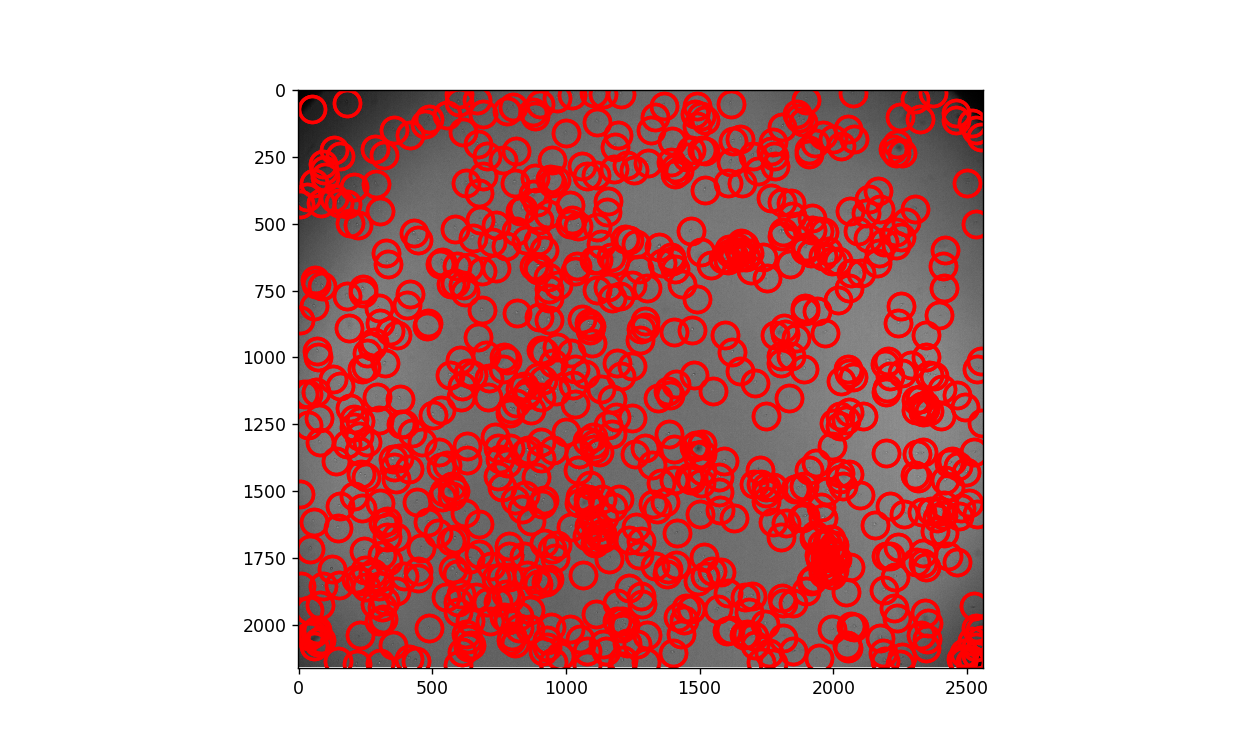

In [114]:
#OK if false cells are detected at this stage//filtering will be done
plt.imshow(frames[0]);

In [115]:
f = tp.locate(frames[0], 11, minmass=3000) #first filter is applied (frames, cell avgsize, min integrated brightness)

In [116]:
len(f)

808

In [118]:
tp.annotate(f, frames[0]); #compare with initial image, it takes some trial and error. Use find maxima in ImageJ for reference.

In [119]:
f = tp.batch(frames, 11, minmass=3000)

Frame 179: 854 features


In [120]:
t = tp.link(f, 5, memory=5)   #specify a maximum displacement, the farthest a particle can travel between frames
                             #memory is how long a particle is tracked after having left the borders in a frame  

Frame 179: 854 trajectories present.


In [121]:
t.mass.max()

50563.30644131584

In [122]:
t1 = tp.filter_stubs(t, 5)    #filter_stubs keeps only trajectories that last for a given number of frames
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 10115
After: 3247


In [123]:
t2 = t1[((t1['mass'] < 40000) & (t1['size']<2.45))] #filter t1 by excluding irregularities

<IPython.core.display.Javascript object>


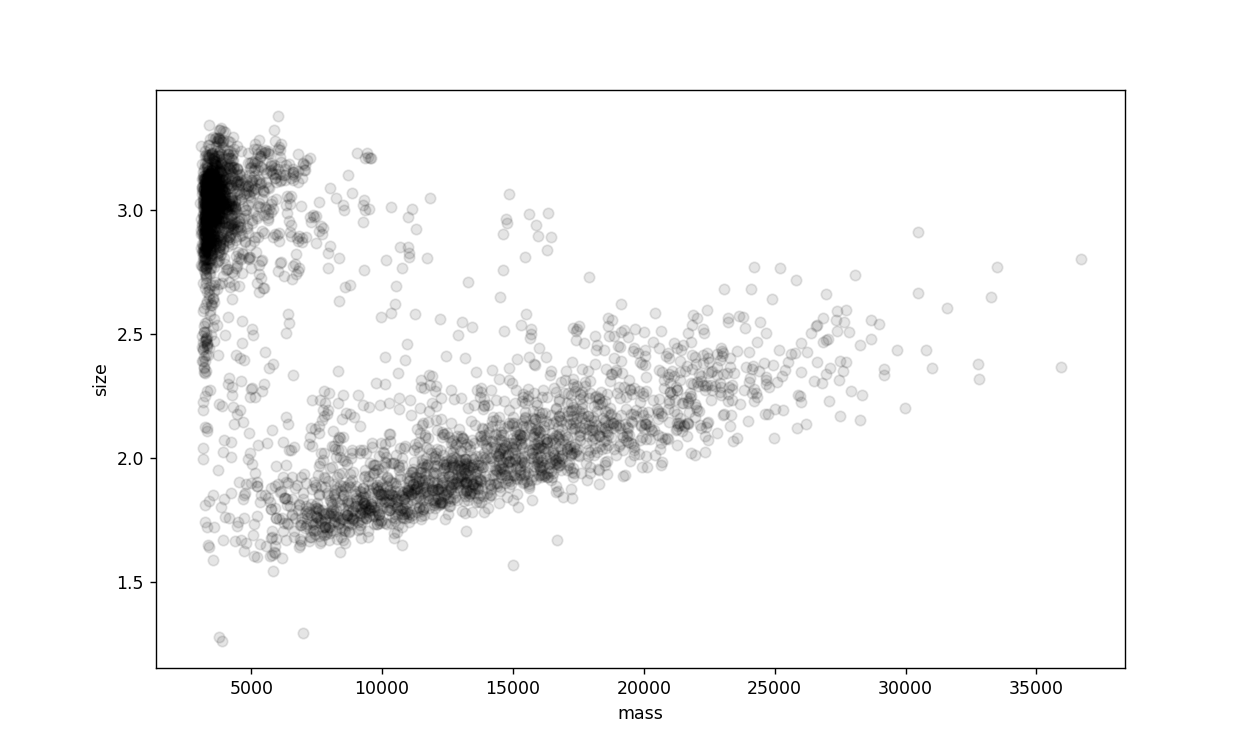

In [124]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); 

In [130]:
t2 = t1[((t1['mass'] < 35000) & (t1['size']<2.8))]

<IPython.core.display.Javascript object>


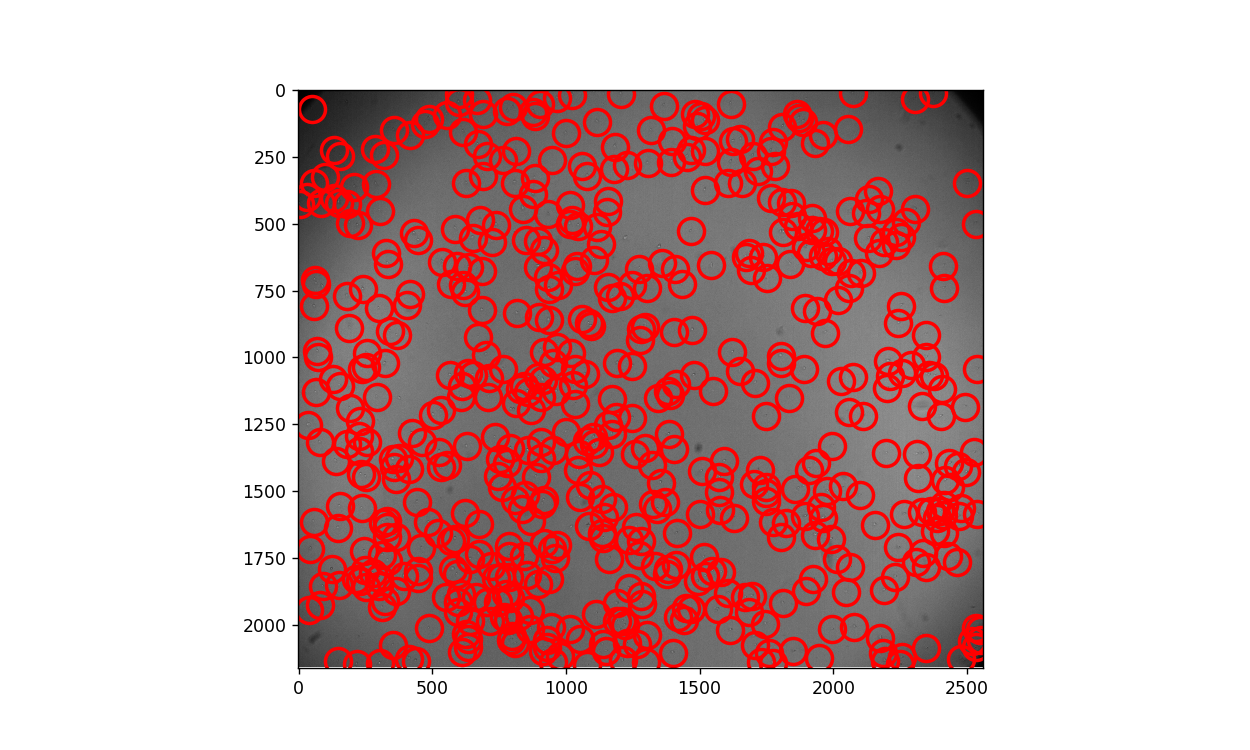

In [131]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0]);  #after all the filtering, these are the particles in FRAME i kept

<IPython.core.display.Javascript object>


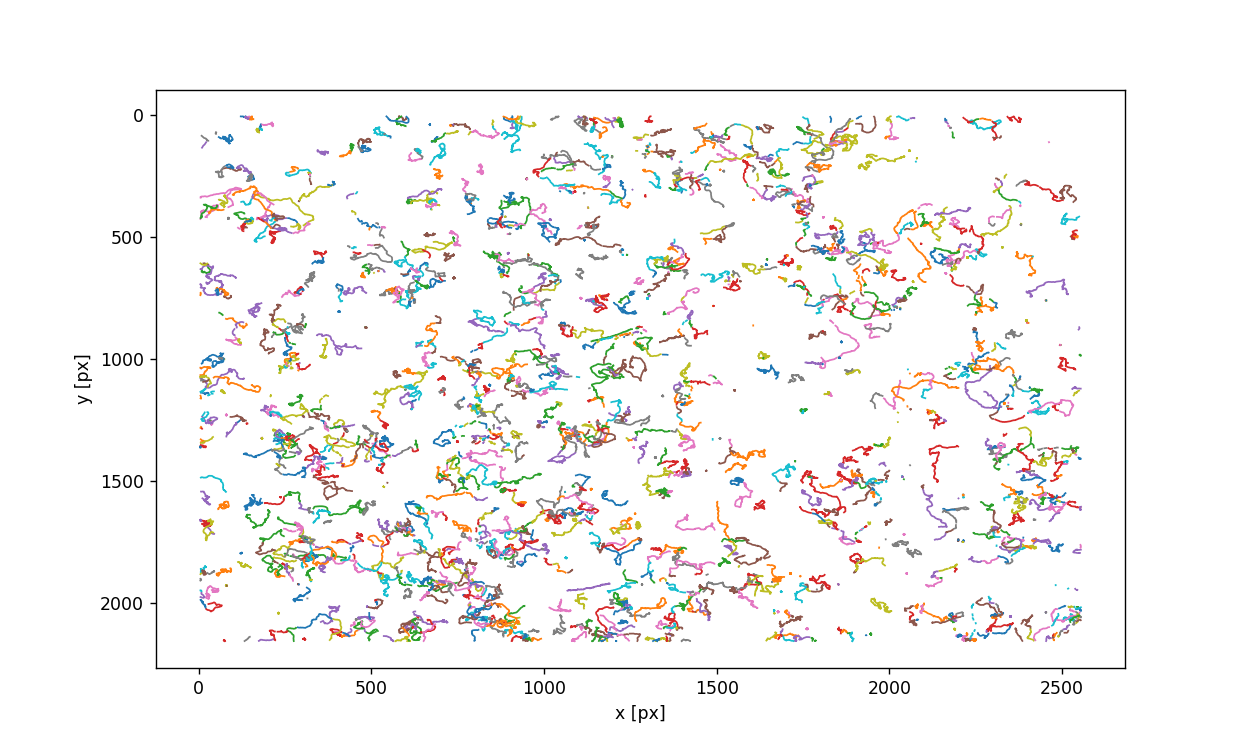

In [132]:
plt.figure()
tp.plot_traj(t2);

In [133]:
d = tp.compute_drift(t2)

<IPython.core.display.Javascript object>


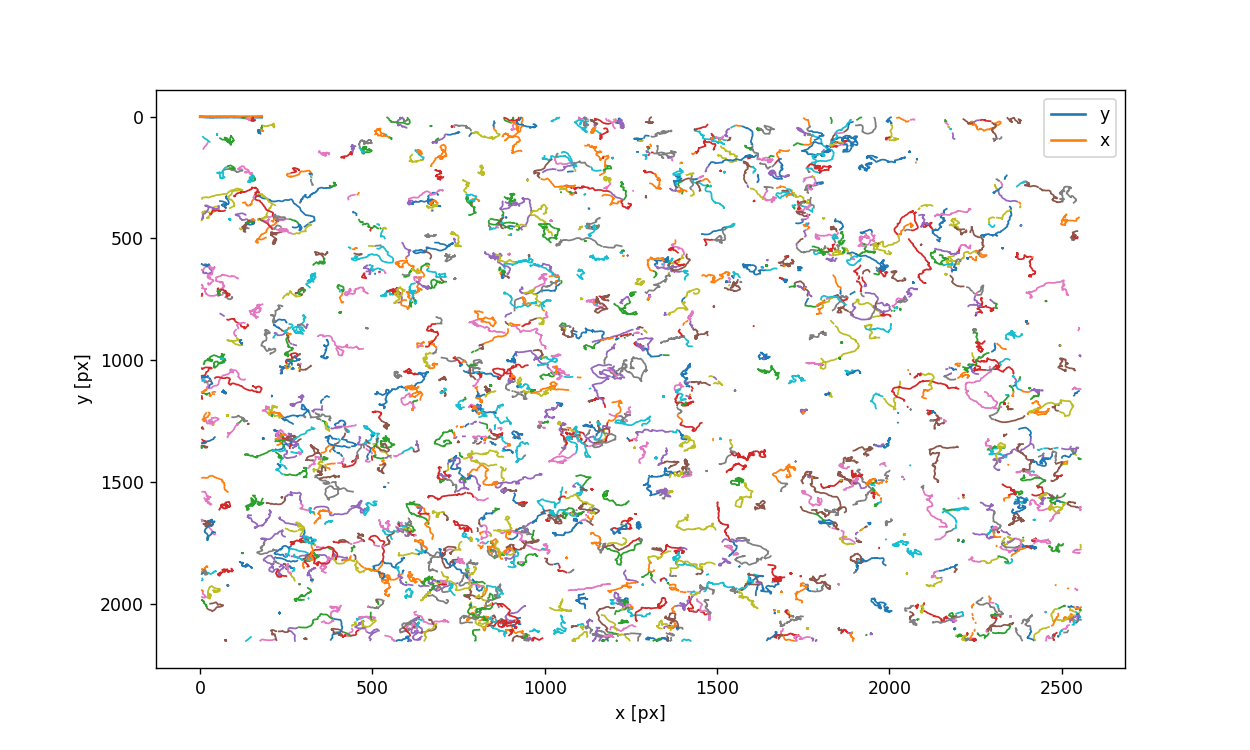

In [134]:
d.plot()
plt.show()

In [135]:
tm = tp.subtract_drift(t2.copy(), d)

In [136]:
ax = tp.plot_traj(tm)
plt.show()

In [137]:
#im = tp.imsd(tm, 1.634, 1/30)   #MSD OF EACH INDIVIDUAL CELL

In [138]:
#fig, ax = plt.subplots()
#ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
#ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
#       xlabel='lag time $t$')
#ax.set_xscale('log')
#ax.set_yscale('log')

In [139]:
em = tp.emsd(tm, 1.634, 1/30, max_lagtime=181) #ENSEMBLE MSD

In [140]:
#RAW PLOT OF EXPERIMENTAL DATA

#fig, ax = plt.subplots()
#ax.plot(em.index, em, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
#       xlabel='lag time $t$')
#ax.set(ylim=(0, 100000));

In [141]:
#TRACKPY'S LINEAR REGRESSION FIT; 
#********Rather avoid it; not enough control of sensitive parameters ; can skew information**************

#plt.figure()
#plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#plt.xlabel('lag time $t$');
#tp.utils.fit_powerlaw(em) 

<IPython.core.display.Javascript object>


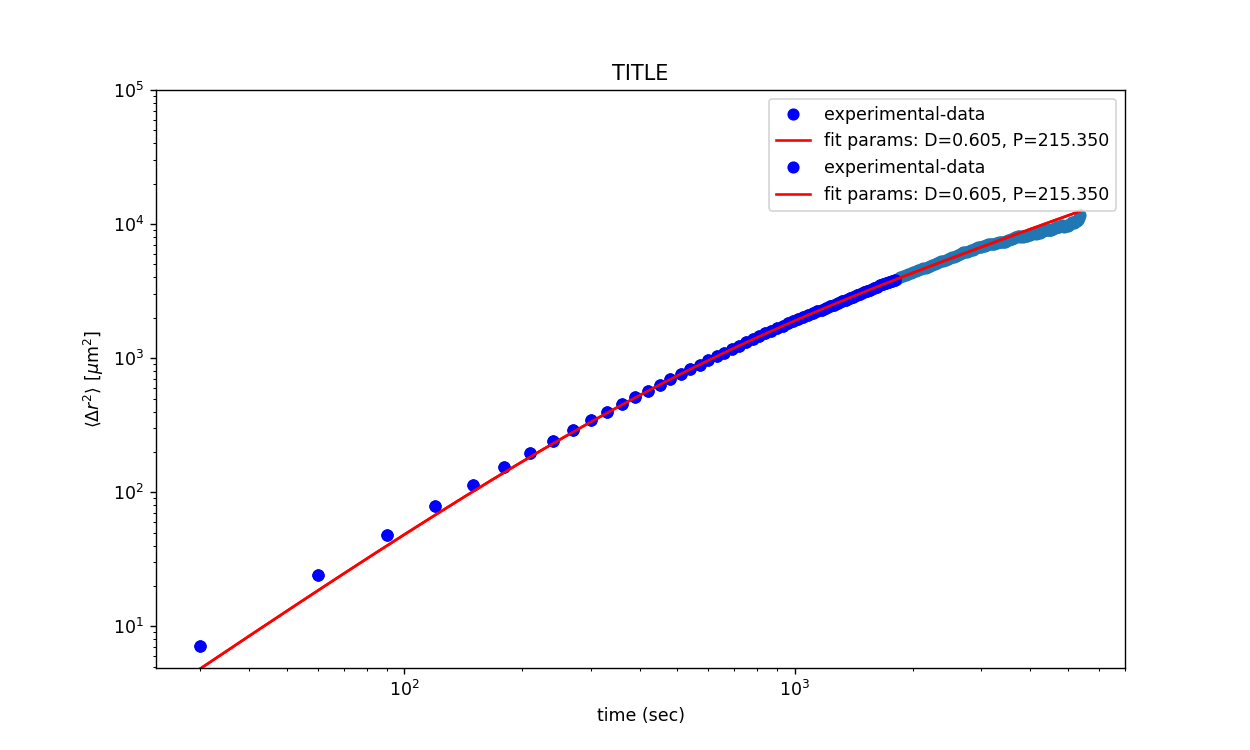

<ipython-input-168-d6e235c0a03a>:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(ylim=(0, 100000));


In [168]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(0, 100000));

In [170]:
#Fitting Furth formula
#My personal fit to ^^, much better results and more parameter control
#fit up to 1/2 of xData as statistical run over N/2 inputs is more heavily iterated; avoid skewed data
#up to N/3 is the ideal case

def func(t, D, P):
    return 4*D*(t-P*(1-(np.exp(-(t/P)))))
    #return a*x+b
 
#Experimental x and y data points    
xData = em.index[0:60]
yData = em[0:1801]

#Plot experimental data points
plt.plot(xData, yData, 'bo', label='experimental-data')
 
# Initial guess for the parameters
#initialGuess = [1.0,1.0]    
 
#Perform the curve-fit
popt, pcov = curve_fit(func, xData, yData)#, initialGuess)
print(popt)
 
#x values for the fitted function
xFit = np.arange(30, (len(frames)*30), 0.01)
 
#Plot the fitted function
plt.plot(xFit, func(xFit, *popt), 'r', label='fit params: D=%5.3f, P=%5.3f' % tuple(popt))

plt.xlabel('time (sec)')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.title('TITLE')
plt.legend()
plt.show()
#plt.ylim(0.5, (len(frames)*30));


[  0.60501793 215.35016902]


In [171]:
len(em.index)

179

<IPython.core.display.Javascript object>


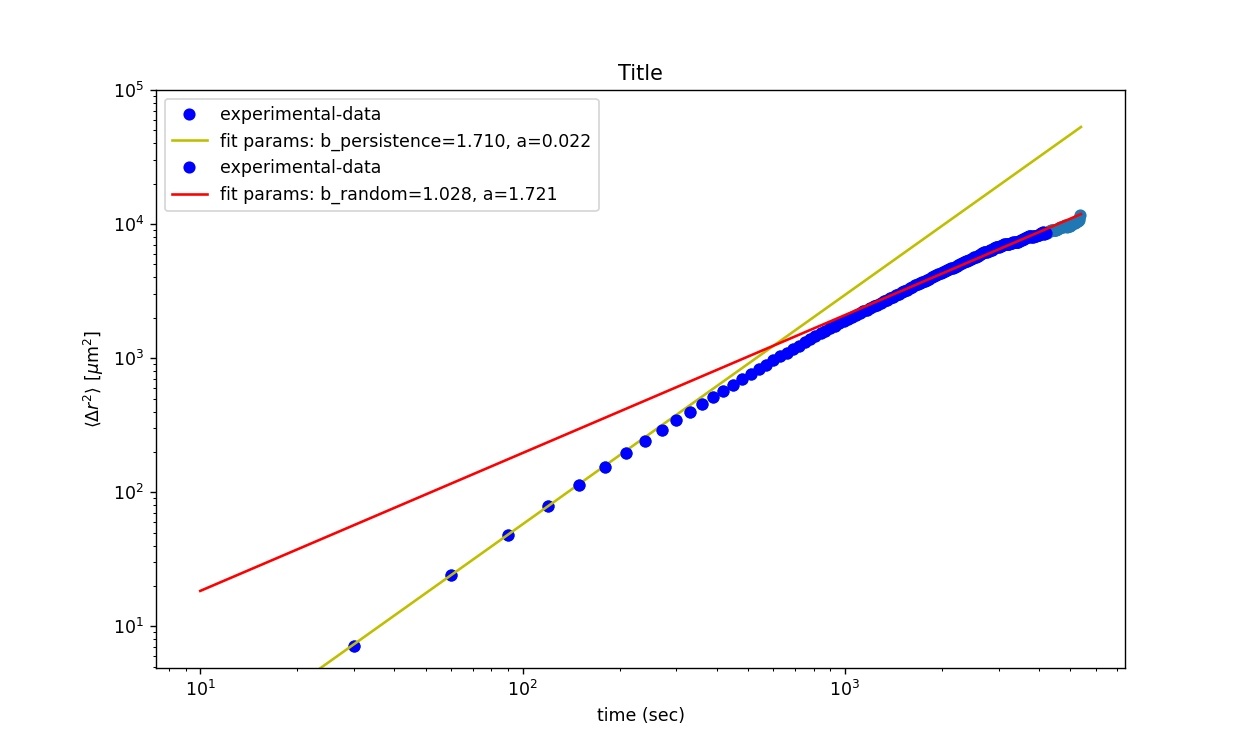

<ipython-input-172-d6e235c0a03a>:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(ylim=(0, 100000));


In [172]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(0, 100000));

In [173]:
#Fitting Power Law with more control 
#My personal fit, much better than trackpy's default : much more control on parameters fit to your experiment

def func(t, b, a):
    return a*(t**(b))
    #return a*x+b
 
#Experimental x and y data points    
xData = em.index[:4]
yData = em[:121]

#Plot experimental data points
plt.plot(xData, yData, 'bo', label='experimental-data')
 
# Initial guess for the parameters
#initialGuess = [1.0,1.0]    
 
#Perform the curve-fit
popt, pcov = curve_fit(func, xData, yData)#, initialGuess)
print(popt)
 
#x values for the fitted function
xFit = np.arange(10, (len(frames)*30), 0.01)
 
#Plot the fitted function
plt.plot(xFit, func(xFit, *popt), 'y', label='fit params: b_persistence=%5.3f, a=%5.3f' % tuple(popt))

plt.xlabel('time (sec)')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.title('Title')
plt.legend()
plt.show()

[1.71035075 0.02189928]


In [174]:
#Experimental x and y data points    
xData = em.index[4:140]
yData = em[121:4201]

#Plot experimental data points
plt.plot(xData, yData, 'bo', label='experimental-data')
 
# Initial guess for the parameters
#initialGuess = [1.0,1.0]    
 
#Perform the curve-fit
popt, pcov = curve_fit(func, xData, yData)#, initialGuess)
print(popt)
 
#x values for the fitted function
xFit = np.arange(10, (len(frames)*30), 0.01)
 
#Plot the fitted function
plt.plot(xFit, func(xFit, *popt), 'r', label='fit params: b_random=%5.3f, a=%5.3f' % tuple(popt))

plt.xlabel('time (sec)')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.title('Title')
plt.legend()
plt.show()

[1.02840043 1.7208832 ]


<IPython.core.display.Javascript object>


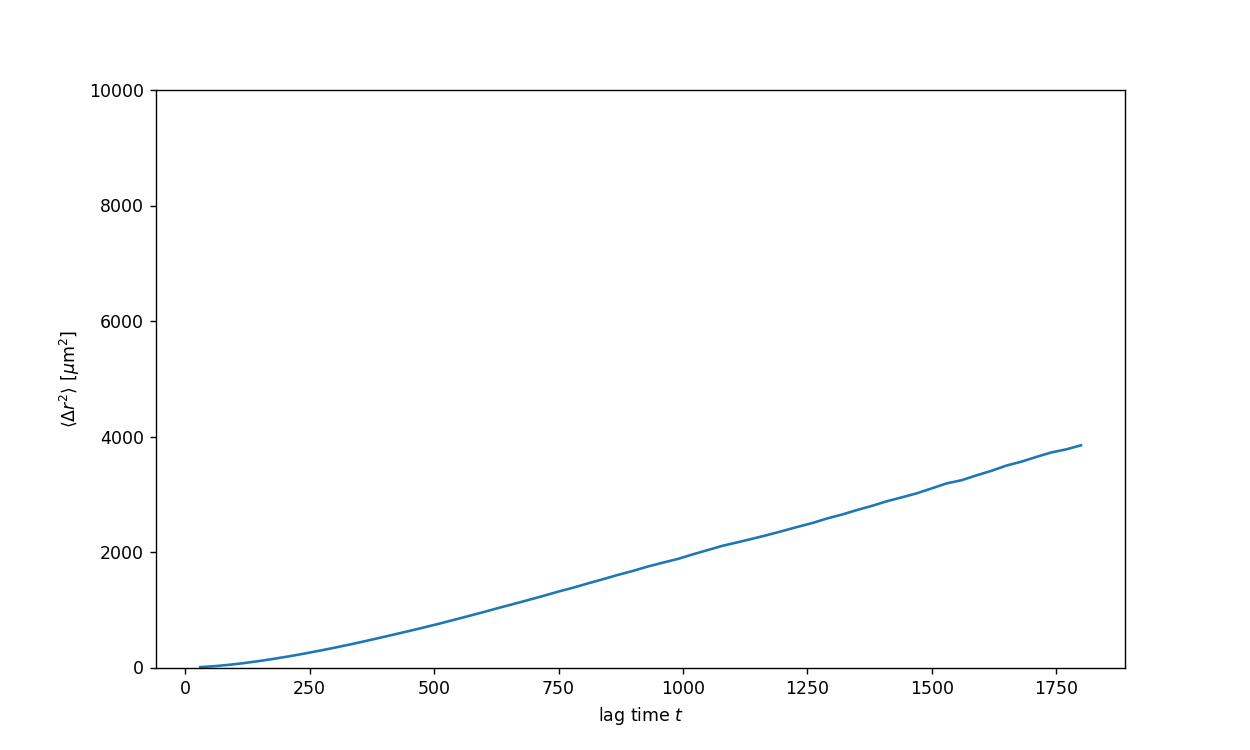

In [175]:
em_classic = tp.emsd(tm, 1.634, 1/30, max_lagtime=60)
fig, ax = plt.subplots()
ax.plot(em_classic.index, em_classic)#, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(0, 10000));

In [176]:
em_classic.head(60)

lagt
30.0         7.136709
60.0        24.051349
90.0        48.380953
120.0       78.713466
150.0      113.874991
180.0      153.253290
210.0      196.052095
240.0      242.371996
270.0      291.605941
300.0      343.299254
330.0      397.247237
360.0      453.723873
390.0      512.584175
420.0      572.352322
450.0      632.389052
480.0      695.035380
510.0      758.488792
540.0      825.363562
570.0      893.162885
600.0      961.337788
630.0     1032.490804
660.0     1100.368984
690.0     1170.055578
720.0     1241.320594
750.0     1315.165660
780.0     1383.356473
810.0     1458.636032
840.0     1530.446729
870.0     1604.813934
900.0     1673.559034
930.0     1749.463958
960.0     1816.195659
990.0     1880.482767
1020.0    1959.291219
1050.0    2033.692213
1080.0    2108.276117
1110.0    2168.482593
1140.0    2230.569930
1170.0    2294.511989
1200.0    2363.245898
1230.0    2434.260365
1260.0    2501.445200
1290.0    2580.908320
1320.0    2649.003614
1350.0    2727.123487
1380.